# 📈 Long & Short Strategy Exploration Using Correlation Analysis


Welcome! This notebook outlines my approach to Long & Short (L&S) strategies, specifically within the context of arbitrage. When working with arbitrage, we encounter a wide range of methodologies—such as R² analysis, cointegration, correlation, and technical indicators. Each offers unique insights into asset relationships and trading opportunities.

In this notebook, I focus on a correlation-based framework to analyze multiple assets and extract actionable information.

🔍 Notebook Structure
This project is divided into two main parts:

Part 1: Data Extraction & Analysis
Retrieve historical price data for selected assets

Compute pairwise correlations

Visualize relationships and highlight potential candidates for mean-reversion

This section is straightforward—pure data handling and exploratory analysis.

Part 2: Mean-Reversion Strategy & Backtest
Construct a basic mean-reversion strategy using correlation insights

Run a backtest to evaluate performance



---



⚠️ Note: This backtest is intentionally simple. It does not include clustering, machine learning, or training processes—just a raw strategy evaluation. With that said, let’s dive into the code and explore how correlation can guide L&S strategy design



#🧮 First Part :

In the first part of this notebook, I’ll download historical market data using yfinance, store it in SQL tables, and calculate key statistical metrics such as maximum, minimum, mean, median, standard deviation, and Buy & Hold return percentages.

This initial analysis helps us understand the nature of the assets we’re working with and allows us to define constraints for strategy design—for example, excluding companies with less than 10% standard deviation or filtering out assets with average trading volume below 1 million. It’s important to establish these filters before diving into strategy development to ensure we’re working with meaningful and liquid instruments.

Finally, we’ll compute the correlation matrix across all tickers to explore potential relationships and identify candidates for the next stage of our Long & Short strategy.


In [4]:
!pip install pandas_ta

In [5]:
import pandas as pd
import yfinance as yf
import datetime as dt
import sqlite3

tickers = [
    "NVDA", "AAPL", "MSFT", "GOOGL", "AMZN", "AVGO", "META", "TSLA",
    "JPM", "WMT", "LLY", "ORCL", "V", "MA", "XOM", "PLTR", "NFLX", "JNJ",
    "AMD", "COST", "BAC", "ABBV", "HD", "PG", "GE", "CVX", "UNH", "KO",
    "CSCO", "IBM", "WFC", "CAT", "MS", "MU", "AXP", "CRM", "GS", "RTX",
    "TMUS", "PM", "APP", "ABT", "MRK", "TMO", "MCD", "DIS", "UBER", "PEP" ]

def download_yfinance(ticker):
    df = yf.download(ticker, auto_adjust = True, period='5y')
    df = df.reset_index()
    df.columns = ['Date','Close', 'High', 'Low', 'Open', 'Volume']
    df['Ticker'] = ticker
    return df

def store_to_sqlite(df, ticker, conn):
    df.to_sql(ticker, conn, if_exists='replace')

def get_summary(df):
    max_price = df.Close.max()
    min_price = df.Close.min()
    mean = df.Close.mean()
    median = df.Close.median()
    std = df.Close.std()
    #buy_hold = (df.Close[-1] / df.Close[0] - 1) * 100
    return [max_price, min_price, mean, median, std]


In [6]:
conn = sqlite3.connect('stocks_data.db')
summary_table = []

for ticker in tickers:
    df = download_yfinance(ticker)
    store_to_sqlite(df, ticker, conn)
    stats = get_summary(df)
    summary_table.append([ticker] + stats)

summary_df = pd.DataFrame(summary_table, columns=['Ticker', 'Max', 'Min', 'Mean', 'Median', 'Std.Dev'])
print(summary_df)

def calculate_matrices(tickers, conn):
    price_data = pd.DataFrame()
    for ticker in tickers:
        df = pd.read_sql(f'SELECT * FROM "{ticker}"', conn, index_col='Date')
        price_data[ticker] = df.Close
    price_data = price_data.dropna()
    cov_matrix = price_data.cov()
    cor_matrix = price_data.corr()
    r2_matrix = cor_matrix**2
    return cov_matrix, cor_matrix, r2_matrix

cov_matrix, cor_matrix, r2_matrix = calculate_matrices(tickers, conn)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

   Ticker          Max         Min        Mean      Median     Std.Dev
0    NVDA   207.039993   11.213527   61.550272   30.814643   53.961969
1    AAPL   271.399994  105.802513  174.599943  169.672569   37.598619
2    MSFT   542.070007  193.999161  334.024282  318.237915   88.494590
3   GOOGL   281.480011   80.659691  138.634574  134.858620   36.605828
4    AMZN   244.220001   81.820000  160.985454  163.483498   38.253796
5    AVGO   385.980011   31.391691  108.479018   61.712637   81.769755
6    META   789.467163   88.365257  374.772624  326.064896  181.862489
7    TSLA   479.859985  108.099998  257.047296  244.125000   71.130214
8     JPM   314.530823   88.046967  167.011942  142.196724   57.158553
9     WMT   109.029999   37.783623   59.216744   49.157816   20.193286
10    LLY   952.733948  123.843460  490.834969  407.226639  255.929512
11   ORCL   327.761200   51.953930  113.599692   94.319504   54.173111
12      V   372.654297  173.635727  249.217853  228.228851   51.411492
13    

Highest correlation pair: ('V', 'MA') with value 0.9859




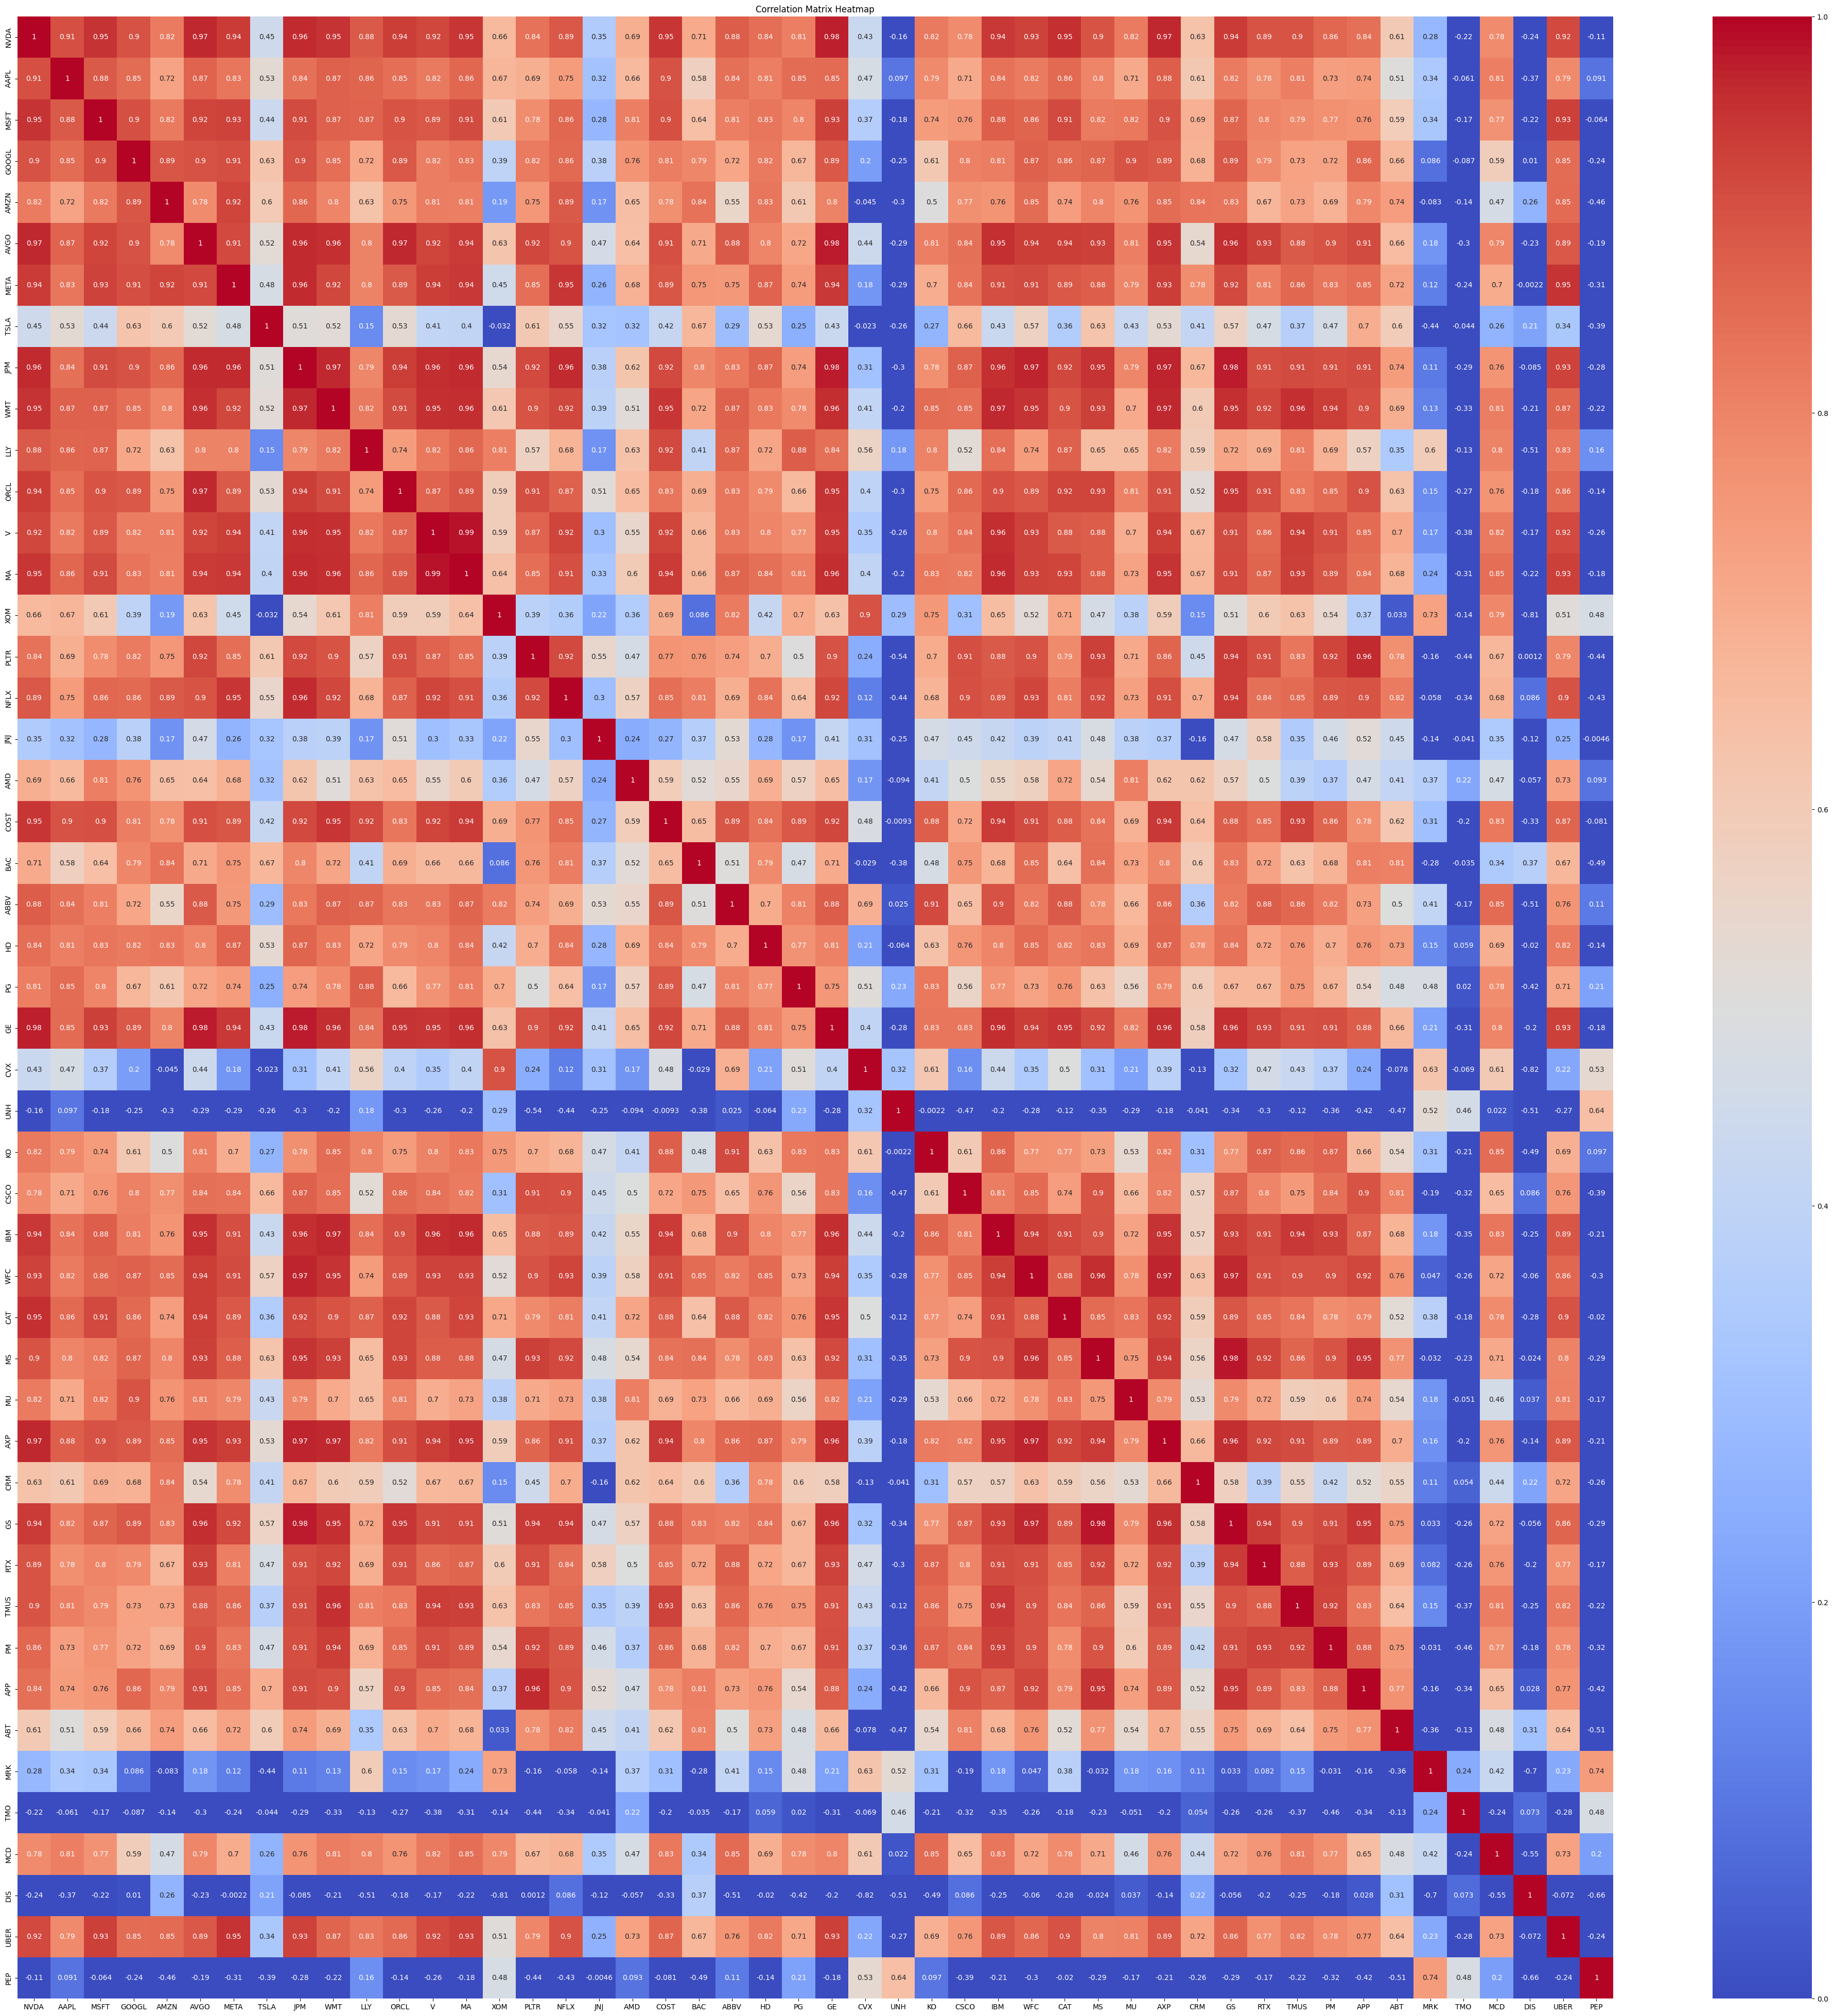

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def print_highest_correlation(cor_matrix):
    # Mask the diagonal (self-correlation) by setting it to NaN
    cor_matrix_no_diag = cor_matrix.copy()
    np.fill_diagonal(cor_matrix_no_diag.values, np.nan)

    # Unstack to get pairs; finds max correlation ignoring diagonal
    highest_pair = cor_matrix_no_diag.unstack().idxmax()
    highest_value = cor_matrix_no_diag.unstack().max()

    print(f'Highest correlation pair: {highest_pair} with value {highest_value:.4f}')
    print("")
    print("")
    return highest_pair

highest_pair = print_highest_correlation(cor_matrix)

plt.figure(figsize=(50, 50))
sns.heatmap(cor_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()



# Second Part:

Now let’s move on to the strategy. Long & Short (L&S) positions can be traded using different approaches, such as price ratios (StockA/StockB) or price differences (StockA - StockB). The choice depends on factors like margin requirements, cash balance, and operational constraints. In this case, we’ll use the price difference method, as it’s easier to interpret and implement. Based on this spread, we’ll visualize the return series and the spread behavior over time. Then, we’ll define a threshold using two times the standard deviation to identify entry and exit signals. For simplicity, we’ll assume a 10% stop loss and a target gain of approximately the greater of the mean return or 10%.

               V_Close    MA_Close      Spread    Return
Date                                                    
2020-11-02  178.245361  281.874695 -103.629333       NaN
2020-11-03  181.718750  287.143341 -105.424591  0.017324
2020-11-04  187.150848  298.623627 -111.472778  0.057370
2020-11-05  190.691803  307.693146 -117.001343  0.049596
2020-11-06  191.492630  304.883820 -113.391190 -0.030856
2020-11-09  205.203094  334.940613 -129.737518  0.144159
2020-11-10  205.810898  325.433594 -119.622696 -0.077964
2020-11-11  205.222397  323.110352 -117.887955 -0.014502
2020-11-12  201.241257  319.124817 -117.883560 -0.000037
2020-11-13  203.386383  325.676636 -122.290253  0.037382


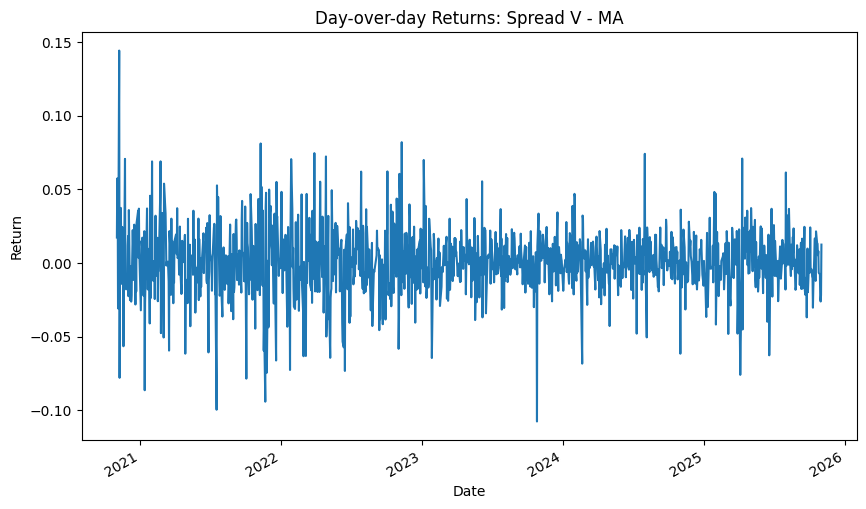

In [8]:

# Example: highest_pair = ('AAPL', 'MSFT')
def fetch_prices(conn, pair):
    dfs = []
    for ticker in pair:
        df = pd.read_sql(f'SELECT Date, [Close] FROM "{ticker}"', conn, parse_dates=['Date'])
        df = df.set_index('Date').rename(columns={'Close': ticker})
        dfs.append(df)
    merged = pd.concat(dfs, axis=1, join='inner')
    return merged

# Get prices for highest correlated pair
conn = sqlite3.connect('stocks_data.db')  # Use your existing DB connection
price_df = fetch_prices(conn, highest_pair)

# Calculate spread and daily returns
strategy_df = pd.DataFrame()
strategy_df[highest_pair[0]+'_Close'] = price_df[highest_pair[0]]
strategy_df[highest_pair[1]+'_Close'] = price_df[highest_pair[1]]
strategy_df['Spread'] = price_df[highest_pair[0]] -price_df[highest_pair[1]]
strategy_df['Return'] = strategy_df['Spread'].pct_change()

print(strategy_df.head(10))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
strategy_df['Return'].plot()
plt.title(f'Day-over-day Returns: Spread {highest_pair[0]} - {highest_pair[1]}')
plt.ylabel('Return')
plt.xlabel('Date')
plt.show()


In [9]:
import pandas_ta as ta

bb_df = ta.bbands(strategy_df['Spread'], length=20, std=2)
bb_df.columns = ['BBLow' , 'BBMid' , "BBHigh" , "BBB" , "BBP"]
strategy_df = pd.concat([strategy_df, bb_df], axis=1)
strategy_df.tail(5)

,V_Close,MA_Close,Spread,Return,BBLow,BBMid,BBHigh,BBB,BBP
Date,,,,,,,,,
2025-10-27,347.820007,572.359985,-224.539978,-0.007733,-233.510380,-223.048975,-212.587569,-9.380366,0.428738
2025-10-28,346.899994,565.929993,-219.029999,-0.024539,-233.128292,-222.666472,-212.204651,-9.396853,0.673797
2025-10-29,341.279999,554.580017,-213.300018,-0.026161,-233.257057,-222.072295,-210.887533,-10.073082,0.892153
2025-10-30,345.029999,553.679993,-208.649994,-0.021800,-232.914082,-220.973853,-209.033624,-10.806916,1.016065
2025-10-31,340.739990,551.989990,-211.250000,0.012461,-231.971763,-220.044118,-208.116473,-10.841139,0.868644


In [10]:
# the strategy if Close <= BBLow : Buy
# the strategy if Close >= BBHigh : Buy
# If isbough or issold and spread = BBmid : close position
# Constrains of 10% in take Profit or Stop Loss


In [11]:
import numpy as np

status = []
entry_price = []
close_price = []
pnl = []

in_position = None   # Can be 'bought', 'sold', or None
entry_val = None

for i, row in strategy_df.iterrows():
    s = "No_Op"
    ep = np.nan
    cp = np.nan
    p = np.nan

    # Entry signals
    if in_position is None:
        if row['Spread'] <= row['BBLow']:
            s = 'Buy'
            in_position = 'bought'
            entry_val = row['Spread']
            ep = row['Spread']
        elif row['Spread'] >= row['BBHigh']:
            s = 'Sell'
            in_position = 'sold'
            entry_val = row['Spread']
            ep = row['Spread']
    else:
        # Hold position or Close
        # Take Profit / Stop Loss / Return to BBMid
        tp_sl_bought = (row['Spread'] - entry_val) / abs(entry_val)
        tp_sl_sold = (entry_val - row['Spread']) / abs(entry_val)
        if (row['Spread'] == row['BBMid']) or \
           (in_position == 'bought' and (tp_sl_bought >= 0.10 or tp_sl_bought <= -0.10)) or \
           (in_position == 'sold' and (tp_sl_sold >= 0.10 or tp_sl_sold <= -0.10)):
            s = 'Close'
            cp = row['Spread']
            ep = entry_val         # Repeat entry
            # PNL calculation
            if in_position == 'bought':
                p = cp - entry_val
            elif in_position == 'sold':
                p = entry_val - cp
            in_position = None
            entry_val = None
        else:
            s = 'isbough' if in_position == 'bought' else 'issold'
            ep = entry_val         # Repeat entry

    status.append(s)
    entry_price.append(ep)
    close_price.append(cp)
    pnl.append(p)

strategy_df['Status'] = status
strategy_df['Entry Price'] = entry_price
strategy_df['Close Price'] = close_price
strategy_df['PNL'] = pnl
strategy_df.sum()

,0
V_Close,313017.62294
MA_Close,515443.014252
Spread,-202425.391312
Return,1.035245
BBLow,-212513.495636
BBMid,-199236.855579
BBHigh,-185960.215522
BBB,-17040.610647
BBP,572.933719
Status,No_OpNo_OpNo_OpNo_OpNo_OpNo_OpNo_OpNo_OpNo_OpN...


count     31.000000
mean      67.596256
std       44.677888
min      -18.329849
25%       37.317657
50%       76.039734
75%      101.201904
max      143.002472
Name: PNL, dtype: float64


<Axes: xlabel='Date'>

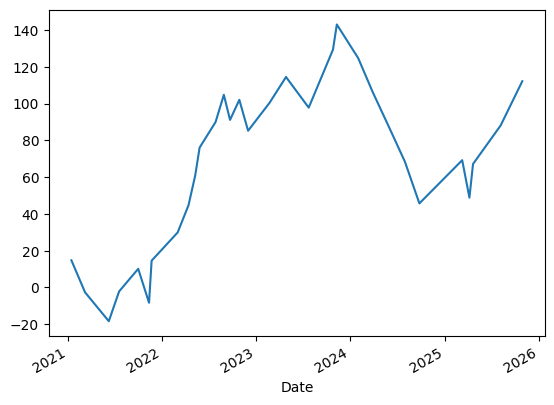

In [38]:
filter = strategy_df.PNL
filter = filter.dropna()
filter['Accum'] = filter.cumsum()
print(filter['Accum'].describe())
filter['Accum'].plot()
